In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch
from torch import nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import torch.nn.functional as F
from torchmetrics import MeanAbsolutePercentageError, MeanAbsoluteError, MeanSquaredError, R2Score
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import yaml
import pandas as pd
import numpy as np
from datasets import Dataset
import torch
from sentence_transformers import SentenceTransformer
from transformers import (
    AutoModelForSequenceClassification, 
    AutoTokenizer,
    TrainingArguments, 
    Trainer
)
from peft import get_peft_model, IA3Config, TaskType
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch.nn as nn
import os

In [14]:
path = "C:\\Users\\Sidewinders\\Desktop\\CODE\\Wine---price-ratings-prediction\\notebooks\\amazon_wine.xlsx"


df = pd.read_excel(path)

# use only price and description as corpus for embeddings training
df = df[['Description', 'Price']].copy()

# Remove rows with missing descriptions

# Remove price outliers using IQR
Q1 = df['Price'].quantile(0.1)
Q3 = df['Price'].quantile(0.9)
IQR = Q3 - Q1
df = df[
    (df['Price'] >= Q1 - 1.5 * IQR) &
    (df['Price'] <= Q3 + 1.5 * IQR)
]
df['Price_Log'] = np.log1p(df['Price'])  # log1p

df = df.dropna(subset=['Description'])
df = df.dropna(subset=['Price'])
print("Shape after preprocessing:", df.shape)
print("/nSample description:")
print(df['Description'].iloc[0])


Shape after preprocessing: (1868, 3)
/nSample description:
The 2022 Château Lafite-Rothschild is based on 94% Cabernet Sauvignon, 5% Merlot, and 1% Petit Verdot that was harvested between the 31st of August and the 24th of September. It's a richer, more opulent wine compared to the more classic 2020 (although the...


# Create the custom PyTorch model, loss function, and Datasets

In [19]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.BatchNorm1d(in_features),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features, in_features),
            nn.BatchNorm1d(in_features)
        )
        
    def forward(self, x):
        return F.relu(x + self.block(x))

class PriceRangeAttention(nn.Module):
    def __init__(self, in_features):
        super(PriceRangeAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        weights = self.attention(x)
        return x * weights
    
class ImprovedWinePricePredictor(nn.Module):
    def __init__(self, embedding_dim):
        super(ImprovedWinePricePredictor, self).__init__()
        
        # Initial layer
        self.input_layer = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Residual blocks
        self.res_blocks = nn.ModuleList([
            ResidualBlock(512) for _ in range(3)
        ])
        
        # Price range attention
        self.attention = PriceRangeAttention(512)
        
        # Output layers
        self.output_layers = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        x = self.input_layer(x)
        
        # Apply residual blocks
        for res_block in self.res_blocks:
            x = res_block(x)
        
        # Apply attention
        x = self.attention(x)
        
        # Output prediction
        return self.output_layers(x)


# Custom loss function that penalizes more for errors in higher prices
class PriceAwareLoss(nn.Module):
    def __init__(self, alpha=0.4):
        super(PriceAwareLoss, self).__init__()
        self.alpha = alpha
        
    def forward(self, pred, target):
        # Basic MSE loss
        mse_loss = F.mse_loss(pred, target, reduction='none')
        
        # Weight factor based on price
        weight = torch.pow(torch.abs(target) + 1, self.alpha)
        
        # Combine losses
        weighted_loss = (mse_loss * weight).mean()
        return weighted_loss
    


class WineDataset(torch.utils.data.Dataset):
    def __init__(self, embeddings, prices):
        self.embeddings = torch.FloatTensor(embeddings)
        self.prices = torch.FloatTensor(prices)
    
    def __len__(self):
        return len(self.prices)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.prices[idx]

def dataloading(df, embeddings):
    # Ensure embeddings match the indices of df
    embeddings = embeddings[:len(df)]
    print(len(embeddings))

    embeddings = embeddings.cpu().numpy()

    # Split the data using log-transformed prices
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, df['Price_Log'].values, 
        test_size=0.2, random_state=42
    )

    # Save original prices for later evaluation
    _, _, y_train_orig, y_test_orig = train_test_split(
        embeddings, df['Price'].values, 
        test_size=0.2, random_state=42
    )


    # Create datasets and dataloaders
    train_dataset = WineDataset(X_train, y_train)
    test_dataset = WineDataset(X_test, y_test)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

    return train_loader, test_loader, y_train_orig,  y_test_orig


def train_model(model, train_loader, test_loader, device, num_epochs=200, patience=100):


    train_losses = []
    val_losses = []

    criterion = PriceAwareLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=200, 
                                     steps_per_epoch=len(train_loader))
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        
        for batch_embeddings, batch_prices in train_loader:
            batch_embeddings = batch_embeddings.to(device)
            batch_prices = batch_prices.to(device).reshape(-1, 1)
            
            optimizer.zero_grad()
            outputs = model(batch_embeddings)

            # Price-aware weighting
            # weights = torch.sqrt(torch.abs(batch_prices) + 1)
            # loss = criterion(outputs * weights, batch_prices * weights)
            
            loss = criterion(outputs, batch_prices)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            
            optimizer.step()
            
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_embeddings, batch_prices in test_loader:
                batch_embeddings = batch_embeddings.to(device)
                batch_prices = batch_prices.to(device).reshape(-1, 1)
                outputs = model(batch_embeddings)
                val_loss += criterion(outputs, batch_prices).item()
        
        train_loss /= len(train_loader)
        val_loss /= len(test_loader)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch}')
                model.load_state_dict(torch.load('best_model.pt'))
                break
        
        
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(test_loader))
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    return model, train_losses, val_losses



def evaluate_model(model, test_loader, y_test_orig, train_losses, val_losses, device):
    # Get predictions
    model.eval()
    y_pred_log = []
    y_true_log = []

    with torch.no_grad():
        for batch_embeddings, batch_prices in test_loader:
            batch_embeddings = batch_embeddings.to(device)
            outputs = model(batch_embeddings).cpu().numpy()
            y_pred_log.extend(outputs)
            y_true_log.extend(batch_prices.numpy())

    y_pred_log = np.array(y_pred_log).reshape(-1)
    y_true_log = np.array(y_true_log)

    # Convert predictions back to original scale
    y_pred = np.expm1(y_pred_log)  # inverse of log1p
    y_true = y_test_orig  # using original prices saved earlier

    # Calculate metrics
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    print("Model Performance Metrics:")
    print(f"R² Score: {r2:.3f}")
    print(f"Mean Absolute Error: ${mae:.2f}")
    print(f"Root Mean Squared Error: ${rmse:.2f}")

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Loss (Log Scale)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Predicted vs Actual Wine Prices')

    plt.tight_layout()
    plt.show()

    # Calculate relative error
    relative_error = np.abs(y_true - y_pred) / y_true * 100
    print(f"\nMedian Relative Error: {np.median(relative_error):.2f}%")

    # Show a few example predictions
    print("\nExample Predictions:")
    for i in range(5):
        print(f"Actual: ${y_true[i]:.2f}, Predicted: ${y_pred[i]:.2f}, "
              f"Difference: ${abs(y_true[i] - y_pred[i]):.2f}, "
              f"Relative Error: {relative_error[i]:.2f}%")

    # Additional analysis of prediction accuracy by price range
    price_ranges = [0, 50, 100, 200, 500, float('inf')]
    print("\nPrediction Accuracy by Price Range:")
    for i in range(len(price_ranges)-1):
        mask = (y_true >= price_ranges[i]) & (y_true < price_ranges[i+1])
        if sum(mask) > 0:
            range_mae = mean_absolute_error(y_true[mask], y_pred[mask])
            range_relative_error = np.median(relative_error[mask])
            print(f"${price_ranges[i]}-${price_ranges[i+1]}: "
                  f"MAE=${range_mae:.2f}, Median Relative Error={range_relative_error:.1f}%")
        


# Generate Embeddings (not using a fine-tuned model yet)

In [10]:
MODEL_NAME = 'sentence-transformers/all-mpnet-base-v2'
CACHE_DIR = './model_cache'  # Local cache directory
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
# Create Sentence Transformer model for embeddings creation
embedding_model = SentenceTransformer(MODEL_NAME, cache_folder=CACHE_DIR)
embedding_model = embedding_model.to(device)

# Get Text input for sentence Transformer
text = df['Description'].tolist()

# Get embeddings from sentence-transformer
embeddings = embedding_model.encode(
    text, # TODO is this list or df format
    convert_to_tensor=True,
    show_progress_bar=True
)

Batches: 100%|██████████| 59/59 [00:04<00:00, 12.46it/s]


In [16]:
embeddings

tensor([[ 0.0052,  0.0826, -0.0302,  ..., -0.0373,  0.0207, -0.0229],
        [ 0.0258,  0.0105, -0.0326,  ...,  0.0054, -0.0334, -0.0234],
        [ 0.0156,  0.0017, -0.0107,  ..., -0.0405,  0.0053, -0.0400],
        ...,
        [ 0.0345, -0.0196,  0.0189,  ...,  0.0235, -0.0148, -0.0374],
        [ 0.0276, -0.0111,  0.0051,  ...,  0.0059,  0.0301, -0.0501],
        [ 0.0243,  0.0425, -0.0233,  ..., -0.0059,  0.0093, -0.0241]],
       device='cuda:0')

Initializing data module...
1868
Initializing model...
Training model...
Epoch [5/50], Train Loss: 0.0160, Val Loss: 0.0522
Epoch [10/50], Train Loss: 0.0123, Val Loss: 0.0491
Epoch [15/50], Train Loss: 0.0098, Val Loss: 0.0518
Epoch [20/50], Train Loss: 0.0079, Val Loss: 0.0466
Epoch [25/50], Train Loss: 0.0065, Val Loss: 0.0462
Epoch [30/50], Train Loss: 0.0066, Val Loss: 0.0526
Early stopping at epoch 32
Evaluating model...
Model Performance Metrics:
R² Score: 0.299
Mean Absolute Error: $69.54
Root Mean Squared Error: $114.48


C:\Users\Sidewinders\AppData\Local\Temp\ipykernel_6132\354251650.py:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


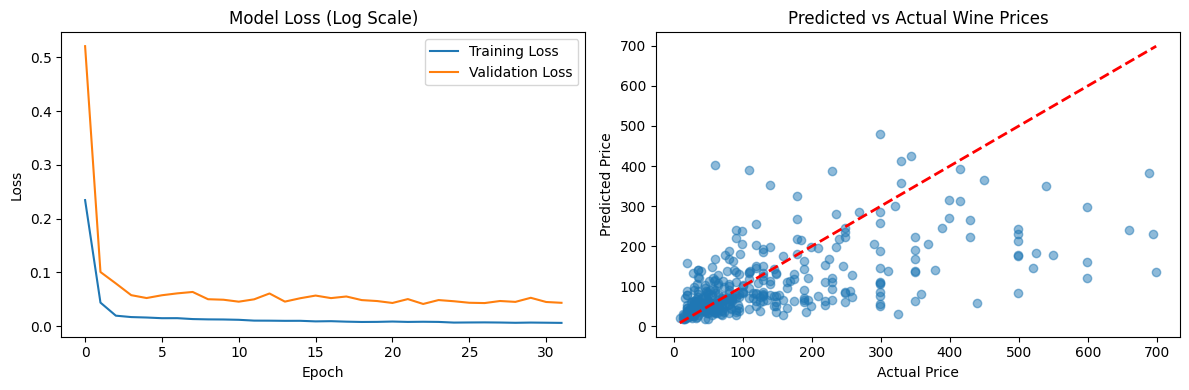


Median Relative Error: 41.91%

Example Predictions:
Actual: $25.99, Predicted: $37.88, Difference: $11.89, Relative Error: 45.73%
Actual: $26.99, Predicted: $26.48, Difference: $0.51, Relative Error: 1.89%
Actual: $79.99, Predicted: $56.24, Difference: $23.75, Relative Error: 29.69%
Actual: $290.00, Predicted: $204.47, Difference: $85.53, Relative Error: 29.49%
Actual: $189.00, Predicted: $143.49, Difference: $45.51, Relative Error: 24.08%

Prediction Accuracy by Price Range:
$0-$50: MAE=$23.18, Median Relative Error=39.3%
$50-$100: MAE=$36.72, Median Relative Error=33.5%
$100-$200: MAE=$65.25, Median Relative Error=40.5%
$200-$500: MAE=$151.14, Median Relative Error=51.3%
$500-$inf: MAE=$385.47, Median Relative Error=66.7%


In [20]:
# Initialize data module
print("Initializing data module...")
train_loader, test_loader, y_train_orig,  y_test_orig = dataloading(df, embeddings)

# Initialize model
print("Initializing model...")
model = ImprovedWinePricePredictor(embeddings.shape[1]).to(device)

# Train model
print("Training model...")
model, train_losses, val_losses = train_model(model, train_loader, test_loader, device=device, num_epochs=50, patience=10)

# Evaluate model
print("Evaluating model...")
evaluate_model(model, test_loader, y_test_orig, train_losses, val_losses, device=device)

# Future Ideas:

- include more features in the embeddings
- Fine-tune the embeddings model
- Test other embedding models